In [35]:
from clickhouse_driver import Client
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
target_item_id = "7d185936-7a60-11eb-ba7f-4a6a34607ded"

In [37]:
# suppose i got this variables from os.environ
db_client = Client(host="82.148.25.91", user="ro_test", password="qwerty", database="test")

## Временные тренды

1. Посмотреть годовой тренд по продаже товаров всех типов и искомого товара
2. Посмотреть недельный тренд для искомого товара

In [38]:
all_max_date, all_period = db_client.execute(
    """
    SELECT max(date(sales.date)), max(date(sales.date)) - min(date(sales.date)) FROM sales
    """
)[0]
print(f"Для всех товаров есть данные за период {all_period} дней, последняя дата -- {all_max_date}")

target_max_date, target_period = db_client.execute(
    f"""
    SELECT max(date(sales.date)), max(date(sales.date)) - min(date(sales.date)) FROM sales
    WHERE sales.item_id = '{target_item_id}'
    """
)[0]
print(f"Для искомого товара есть данные за период {target_period} дней, последняя дата -- {target_max_date}")

Для всех товаров есть данные за период 499 дней, последняя дата -- 2022-01-07
Для искомого товара есть данные за период 360 дней, последняя дата -- 2021-12-30


Есть данные за ~1.5 года

Рассмотрим данные о продажах только за последний год

In [39]:
def plot_week_num_quantity_trend(sql_data: list[tuple[int, int]], ax=None):
    df = pd.DataFrame(data=sql_data, columns=["week_num", "quantity"])
    sns.barplot(data=df, x="week_num", y="quantity", ax=ax)

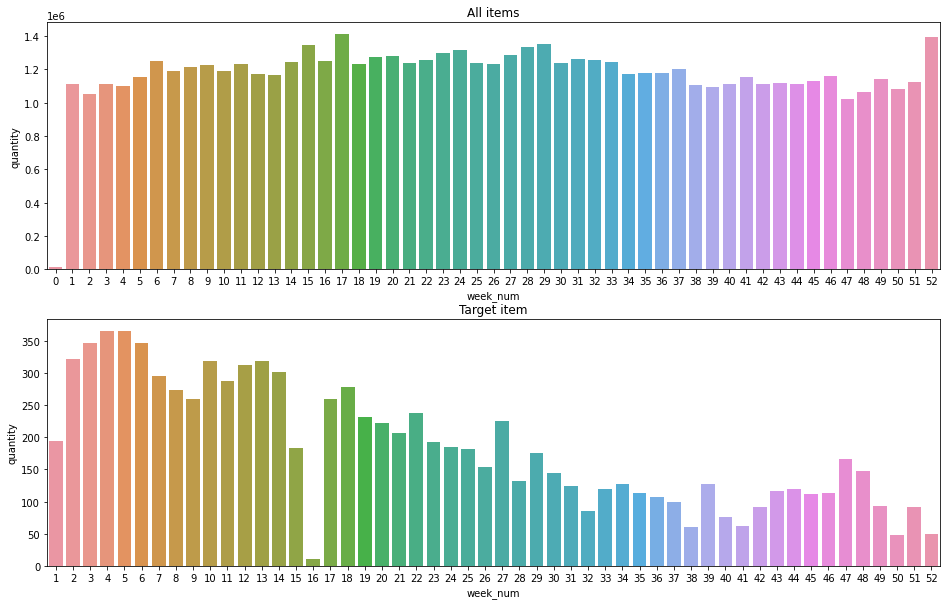

In [40]:
# тренд по номеру недели в году

all_year_weeks_trend = db_client.execute(
    f"""
    SELECT toWeek(sales.date), sum(sales.quantity) FROM sales
    WHERE dateDiff('day', date(sales.date), date(toDateTime('{all_max_date}'))) <= 365
    GROUP BY toWeek(sales.date)
    ORDER BY toWeek(sales.date)
    """
)

target_year_weeks_trend = db_client.execute(
    f"""
    SELECT toWeek(sales.date), sum(sales.quantity) FROM sales
    WHERE (dateDiff('day', date(sales.date), date(toDateTime('{target_max_date}'))) <= 365) AND (sales.item_id = '{target_item_id}')
    GROUP BY toWeek(sales.date)
    ORDER BY toWeek(sales.date)
    """
)

fig, (ax_all, ax_target) = plt.subplots(2, figsize=(16, 10))

ax_all.set_title("All items")
plot_week_num_quantity_trend(all_year_weeks_trend, ax_all)

ax_target.set_title("Target item")
plot_week_num_quantity_trend(target_year_weeks_trend, ax_target)

Видно, что спрос на все товары в среднем одинаковый в течении года, а популярность искомого товара макисмальна в начале года и падает к его концу

Из этого можно сделать вывод, что при предсказании количества товара надо учитывать номер недели в году

In [41]:
def plot_week_day_quantity_trend(sql_data: list[tuple[int, int]], ax=None):
    df = pd.DataFrame(data=sql_data, columns=["week_day", "quantity"])
    sns.barplot(data=df, x="week_day", y="quantity", ax=ax)

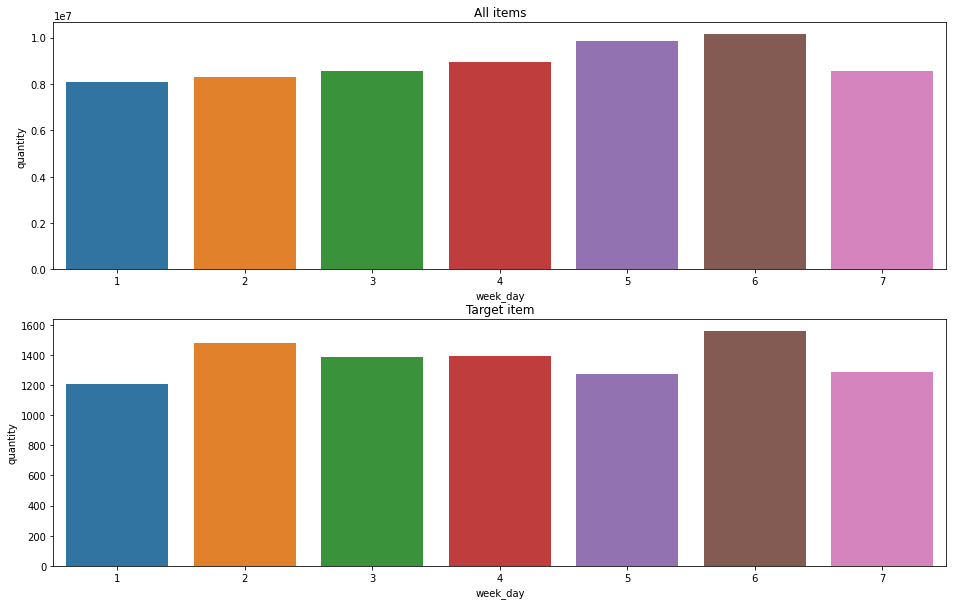

In [42]:
# тренд по дню недели

all_week_day_trend = db_client.execute(
    f"""
    SELECT toDayOfWeek(sales.date), sum(sales.quantity) FROM sales
    WHERE dateDiff('day', date(sales.date), date(toDateTime('{all_max_date}'))) <= 365
    GROUP BY toDayOfWeek(sales.date)
    ORDER BY toDayOfWeek(sales.date)
    """
)

target_week_day_trend = db_client.execute(
    f"""
    SELECT toDayOfWeek(sales.date), sum(sales.quantity) FROM sales
    WHERE (dateDiff('day', date(sales.date), date(toDateTime('{target_max_date}'))) <= 365) AND (sales.item_id = '{target_item_id}')
    GROUP BY toDayOfWeek(sales.date)
    ORDER BY toDayOfWeek(sales.date)
    """
)

fig, (ax_all, ax_target) = plt.subplots(2, figsize=(16, 10))

ax_all.set_title("All items")
plot_week_day_quantity_trend(all_week_day_trend, ax_all)

ax_target.set_title("Target item")
plot_week_day_quantity_trend(target_week_day_trend, ax_target)

Снова тренды у всех товаров и искомого отличаются: искомый товар покупается лучше всего во вторник и субботу

## Получение данных для искомого товара

Возьмем из базы данных информацию по дню недели, номеру недели и количеству продаж для искомого товара

In [84]:
target_data = db_client.execute(
    f"""
    SELECT toWeek(sales.date), toDayOfWeek(sales.date), sum(sales.quantity) FROM sales
    WHERE sales.item_id = '{target_item_id}'
    GROUP BY toWeek(sales.date), toDayOfWeek(sales.date)
    """
)
target_df = pd.DataFrame(data=target_data, columns=["week_num", "week_day", "quantity"])
target_df.head()

,week_num,week_day,quantity
0,1,1,9
1,2,1,22
2,3,1,39
3,4,1,49
4,5,1,38


Посмотрим, как выглядит распределение продаж в году

In [99]:
def data_to_heatmap(data: np.ndarray):
    """
    data: [(week_num, week_day, quantity), ...]
    """
    
    quantity_matrix = np.zeros((52, 7), dtype=int)
    for i, week_num in enumerate(range(1, 52+1)):
        for j, week_day in enumerate(range(1, 7+1)):
            week_num_day_data = target_np[(target_np[:, 0] == week_num) & (target_np[:, 1] == week_day)]
            quantity_matrix[i, j] = int(week_num_day_data[0, 2]) if len(week_num_day_data) > 0 else 0
    
    return quantity_matrix

In [106]:
def display_week_num_day_heatmap(heatmap):
    fig, ax = plt.subplots(1, figsize=(8, 16))
    ax.set_title("Heatmap for week_num/week_day")
    ax.set_ylabel("week_num")
    ax.set_xlabel("week_day")

    sns.heatmap(heatmap, ax=ax)

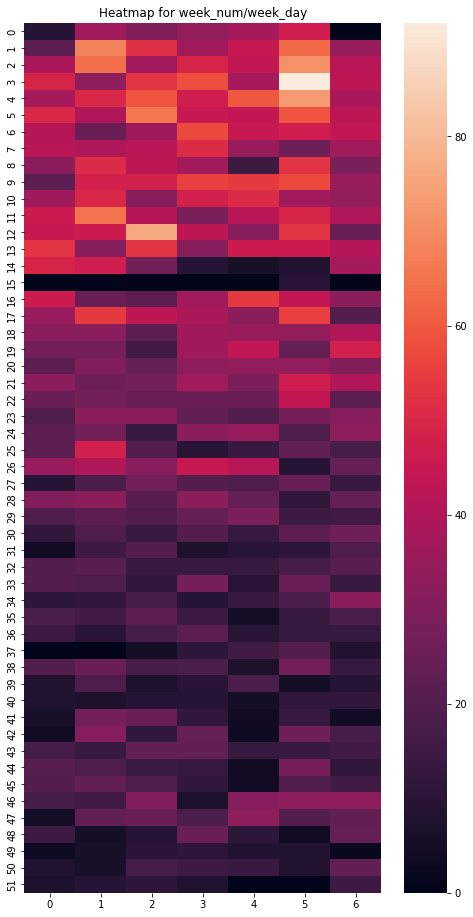

In [108]:
heatmap = data_to_heatmap(np.array(target_df))
display_week_num_day_heatmap(heatmap)

### Обучение линейной модели

In [143]:
from itertools import product
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR

In [174]:
data_np = np.array(target_df, dtype=np.float32)

In [176]:
def test_model(model, X, y):
    model.fit(X, y)
    print(f"R^2 = {model.score(X, y)}")
    return model

Первая идея -- обучить модели на номере недели и номере дня недели

In [177]:
X, y = data_np[:, [0, 1]], data_np[:, 2]

In [178]:
regression = test_model(LinearRegression(n_jobs=-1), X, y)

week_num_c, week_day_c = regression.coef_
delta = regression.intercept_

print(f"quantity = week_num * {week_num_c:.3f} + week_day * {week_day_c:.3f} + {delta:.3f}")

R^2 = 0.5499333892669105
quantity = week_num * -0.782 + week_day * 0.210 + 47.071


In [179]:
ridge = test_model(Ridge(), X, y)

R^2 = 0.5499333790118947


In [180]:
svr = test_model(SVR(kernel="linear"), X, y)

R^2 = 0.5437491673738764


Далее по исходному heatmap'у можно предположить, что количество товара зависит от дня недели нелинейно

Преобразуем номер дня недели с помощью OneHotEncoding:

In [181]:
week_num[:20], week_day_num[:20]

(array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20,
        21], dtype=object),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       dtype=object))

In [182]:
week_num, week_day_num, quantity = data_np[:, 0], data_np[:, 1], data_np[:, 2]

week_day_encoder = OneHotEncoder(sparse=False).fit(week_day_num.reshape(-1, 1))
week_day_onehot = week_day_encoder.transform(week_day_num.reshape(-1, 1))

X_weekday_onehot = np.concatenate([week_num.reshape(-1, 1), week_day_onehot], axis=1)

In [186]:
regression = test_model(LinearRegression(n_jobs=-1), X_weekday_onehot, quantity)

week_num_c, *week_days_c = regression.coef_
delta = regression.intercept_

week_categories = week_day_encoder.categories_[0]
week_day_desc = " + ".join(
    f"day_{cat} * {coef:.3f}" for cat, coef in zip(week_categories, week_days_c)
)

print(f"quantity = {delta:.3f} + week_num * {week_num_c:.3f} + {week_day_desc}")

R^2 = 0.5655159828894777
quantity = 47.874 + week_num * -0.781 + day_1.0 * -3.045 + day_2.0 * 2.355 + day_3.0 * 0.187 + day_4.0 * 0.227 + day_5.0 * -1.884 + day_6.0 * 3.048 + day_7.0 * -0.887


In [187]:
ridge = test_model(Ridge(), X_weekday_onehot, quantity)

R^2 = 0.565509799935137


In [188]:
svr = test_model(SVR(kernel="linear"), X_weekday_onehot, quantity)

R^2 = 0.5529906607815027


Самой лучшей моделью оказалась LinearRegression, ее R^2 = 0.56

Сделаем предсказание на следующую неделю

In [189]:
import datetime

In [190]:
final_model = regression = test_model(LinearRegression(n_jobs=-1), X_weekday_onehot, quantity)

R^2 = 0.5655159828894777


In [194]:
dates = [
    datetime.date(year=2022, month=1, day=d)
    for d in range(17, 23+1)
]
test_week_num = np.array([d.isocalendar().week for d in dates], dtype=np.float32)
test_week_day_num = np.array([d.weekday() + 1 for d in dates], dtype=np.float32)
test_week_day_onehot = week_day_encoder.transform(test_week_day_num.reshape(-1, 1))

test_features = np.concatenate([test_week_num.reshape(-1, 1), test_week_day_onehot], axis=1)
pred_quantity = final_model.predict(test_features)

In [202]:
result_df = pd.DataFrame(data=[(d, int(q)) for d, q in zip(dates, pred_quantity)], columns=["dates", "quantities"], index=None)
result_df.head()

,dates,quantities
0,2022-01-17,42
1,2022-01-18,47
2,2022-01-19,45
3,2022-01-20,45
4,2022-01-21,43


In [205]:
result_df.to_csv("linear_regression.csv", index=False)